## Loading model

Please replace the `CKPT_PATH` to where the checkpoints saved.

In [1]:
CFG_PATH = '../configs/kl16_content12.yaml'
CKPT_PATH = '../checkpoints/artfusion/artfusion_r12_step=317673.ckpt'

H = 256
W = 256
DDIM_STEPS = 250
ETA = 1.
SEED = 2023
DEVICE = 'cuda'

In [2]:
import sys
sys.path.append('../')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import random
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_lightning import seed_everything
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
from einops import rearrange
from omegaconf import OmegaConf
import albumentations

from main import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

seed_everything(SEED)

config = OmegaConf.load(CFG_PATH)
config.model.params.ckpt_path = CKPT_PATH
config.model.params.first_stage_config.params.ckpt_path = None
model = instantiate_from_config(config.model)
model = model.eval().to(DEVICE)

Global seed set to 2023


DualCondLDM: Running in eps-prediction mode
DualConditionDiffusionWrapper has 181.02 M params.
Keeping EMAs of 205.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Training DualCondLDM as an adaptive conditional model.
Keeping EMAs of 3.
Restored from ../checkpoints/artfusion/artfusion_r12_step=317673.ckpt with 0 missing and 0 unexpected keys


In [3]:
def preprocess_image(image_path, size=(W, H)):
    image = Image.open(image_path)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = image.resize(size)
    image = np.array(image).astype(np.uint8)
    image = (image/127.5 - 1.0).astype(np.float32)
    image = rearrange(image, 'h w c -> c h w')
    return torch.from_numpy(image)


def display_samples(samples, n_columns=1, figsize=(12, 12)):
    if isinstance(samples, (list, tuple)):
        samples = torch.cat(samples, dim=0)
        
    samples = rearrange(samples, '(n m) c h w -> (m h) (n w) c', n=n_columns).cpu().numpy() * 255.
    samples = Image.fromarray(samples.astype(np.uint8))
    plt.rcParams["figure.figsize"] = figsize
    plt.imshow(samples)
    plt.axis('off')
    plt.show()

def tensor_to_rgb(x):
    return torch.clamp((x + 1.0) / 2.0, min=0.0, max=1.0)

In [4]:
'''root_style = '/home/hfle/dataset/website_for_replace/source_style/'
style_image_paths = os.listdir("/home/hfle/dataset/website_for_replace/source_style")
style_image_paths.sort()
for index in range(len(style_image_paths)):
    style_image_paths[index] = root_style + style_image_paths[index]'''

## Style Visulization

In [9]:
style_image_paths = [
    '../data/styles/d523d66a2f745aff1d3db21be993093fc.jpg',
    '../data/styles/the_scream.jpg',
    '../data/styles/Claude_Monet_73.jpg',
    '../data/styles/430f12a69a198bf3228f8177ed436624c.jpg'
]
style_images = torch.stack([preprocess_image(p) for p in style_image_paths], dim=0).to(DEVICE)

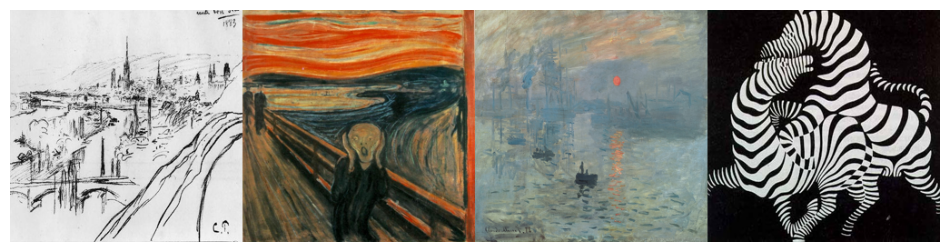

In [10]:
display_samples(tensor_to_rgb(style_images), n_columns=len(style_images))

Use the partial style-conditional model to visualize the style learned by ArtFusion.

In [11]:
bs = len(style_images)

with torch.no_grad(), model.ema_scope("Plotting"):
    c_content = torch.zeros((bs, model.channels, model.image_size, model.image_size)).to(DEVICE)

    vgg_features = model.vgg(model.vgg_scaling_layer(style_images))
    c_style = model.get_style_features(vgg_features)

    c = {'c1': c_content, 'c2': c_style}

    samples = model.sample_log(cond=c, batch_size=bs, ddim=True, ddim_steps=DDIM_STEPS, eta=1.)[0]

    x_samples = model.decode_first_stage(samples)
    x_samples = tensor_to_rgb(x_samples)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (4, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.14it/s]

Plotting: Restored training weights


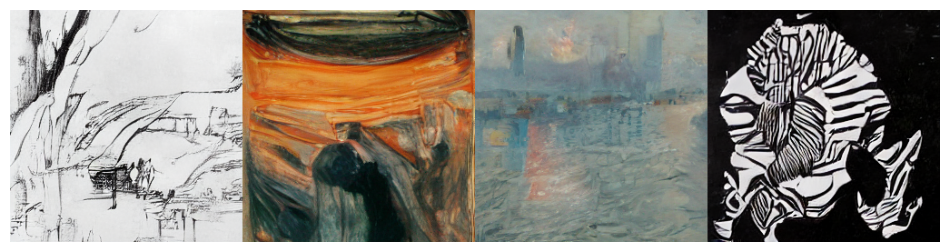

In [12]:
display_samples(x_samples, n_columns=bs)

## Style Transfer

In [13]:
def get_content_style_features(content_image_path, style_image_path, h=H, w=W):
    style_image = preprocess_image(style_image_path)[None, :].to(DEVICE)
    content_image = preprocess_image(content_image_path, size=(w, h))[None, :].to(DEVICE)
    
    with torch.no_grad(), model.ema_scope("Plotting"):
        vgg_features = model.vgg(model.vgg_scaling_layer(style_image))
        c_style = model.get_style_features(vgg_features)
        null_style = c_style.clone()
        null_style[:] = model.null_style_vector.weight[0]

        content_encoder_posterior = model.encode_first_stage(content_image)
        content_encoder_posterior = model.get_first_stage_encoding(content_encoder_posterior)
        c_content = model.get_content_features(content_encoder_posterior)
        null_content = torch.zeros_like(c_content)
        
    c = {'c1': c_content, 'c2': c_style}
    c_null_style = {'c1': c_content, 'c2': null_style}
    c_null_content = {'c1': null_content, 'c2': c_style}
    
    return c, c_null_style, c_null_content
    

def style_transfer(
    content_image_path, style_image_path,
    h=H, w=W,
    content_s=1., style_s=1.,
    ddim_steps=DDIM_STEPS, eta=ETA,
):
    c, c_null_style, c_null_content = get_content_style_features(content_image_path, style_image_path, h, w)
    
    with torch.no_grad(), model.ema_scope("Plotting"):
        samples = model.sample_log(
            cond=c, batch_size=1, x_T = torch.rand_like(c['c1']),
            ddim=True, ddim_steps=ddim_steps, eta=eta,
            unconditional_guidance_scale=content_s, unconditional_conditioning=c_null_content,
            unconditional_guidance_scale_2=style_s, unconditional_conditioning_2=c_null_style)[0]

        x_samples = model.decode_first_stage(samples)
        x_samples = tensor_to_rgb(x_samples)
    
    return x_samples

In [14]:
content_image_path = '../data/contents/lofoton.jpg'
style_image_path = '../data/styles/d523d66a2f745aff1d3db21be993093fc.jpg'

style_image = preprocess_image(style_image_path)[None, :]
content_image = preprocess_image(content_image_path)[None, :]

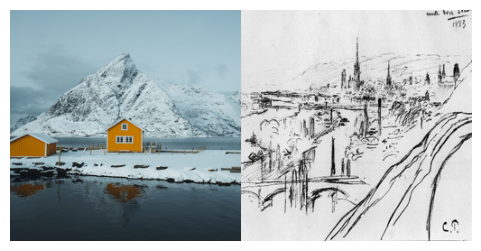

In [15]:
display_samples((tensor_to_rgb(content_image), tensor_to_rgb(style_image)), figsize=(6, 3), n_columns=2)

In [16]:
x_samples = style_transfer(content_image_path, style_image_path, content_s=0.5, style_s=2.)

Plotting: Switched to EMA weights
Plotting: Restored training weights
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.30it/s]

Plotting: Restored training weights


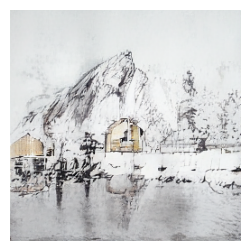

In [17]:
display_samples(x_samples, figsize=(3, 3))

## Two Dimensional Classifier-Free Guidance (2D-CFG)

The `content_scalers` and `style_scalers` are used to adjust the balance of content and style. With a higher content scaler, outputs will show clearer content. On the other hand, a higher style scaler results in a stronger stylization.

In [18]:
def two_dim_cfg(
    content_image_path, style_image_path,
    content_scalers = [0.25, 0.5, 1.0, 2.0, 4.0], style_scalers = [0.15, 0.5, 1., 3., 5.],
    ddim_steps=DDIM_STEPS, eta=ETA,
):
    c, c_null_style, c_null_content = get_content_style_features(content_image_path, style_image_path)
    
    with torch.no_grad(), model.ema_scope("Plotting"):
        samples = list()
        for style_s in style_scalers:
            for content_s in content_scalers:
                sample = model.sample_log(
                    cond=c, batch_size=1,
                    ddim=True, ddim_steps=ddim_steps, eta=eta,
                    unconditional_guidance_scale=content_s, unconditional_conditioning=c_null_content,
                    unconditional_guidance_scale_2=style_s, unconditional_conditioning_2=c_null_style)[0]
                samples.append(sample)
        samples = torch.cat(samples, dim=0)
        x_samples = model.decode_first_stage(samples)
        x_samples = tensor_to_rgb(x_samples)
        
    return x_samples

In [ ]:
x_samples = two_dim_cfg(content_image_path, style_image_path)

Plotting: Switched to EMA weights
Plotting: Restored training weights
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.74it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.83it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 41.58it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.68it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.83it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.77it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 42.65it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:04<00:00, 50.00it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 43.88it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 43.75it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.96it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 49.78it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:04<00:00, 50.59it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:04<00:00, 50.16it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████| 250/250 [00:05<00:00, 49.42it/s]


Data shape for DDIM sampling is (1, 16, 16, 16), eta 1.0
Running DDIM Sampling with 250 timesteps


DDIM Sampler:  32%|█████████████████▌                                     | 80/250 [00:01<00:03, 43.80it/s]

The content scaler increase from top to down, and style scalers increment from left to right.

In [ ]:
display_samples(x_samples, n_columns=5)

## Quick Sampling

For quick sampling, we can use only 10 `ddim_steps` along with `eta = 0.0` without serious loss of visual quality.

In [ ]:
x_samples = two_dim_cfg(content_image_path, style_image_path, ddim_steps=10, eta=0.)

In [ ]:
display_samples(x_samples, n_columns=5)

## High Resolution Sampling

We can adopt lower `content_s` when working on high-resolution images.

In [ ]:
content_image_path = '../data/contents/sicao.jpg'
style_image_path = '../data/styles/df66247b2563f34f74259b4946d3c22ac.jpg'

style_image = preprocess_image(style_image_path)[None, :]
content_image = preprocess_image(content_image_path, size=(1920, 480))[None, :]

In [ ]:
display_samples(tensor_to_rgb(content_image))

In [ ]:
display_samples(tensor_to_rgb(style_image), figsize=(3, 3))

In [ ]:
x_samples = style_transfer(content_image_path, style_image_path, h=480, w=1920, content_s=0.3, style_s=2.)

In [ ]:
display_samples(x_samples)